Before running this notebook, please make sure to install the required Python libraries and spaCy's English language model. These can be found in the `requirements.txt` file and can be installed by using `pip install -r requirements.txt`. We recommend doing so inside a [Python virtual enviroment](https://www.w3schools.com/python/python_virtualenv.asp).

Once the required libraries have been installed, import them by running the cell below. 

In [65]:
import en_core_web_sm
import pandas as pd
import requests
import spacy
from pathlib import Path
from spacy.symbols import NORM, ORTH

 We start by retrieving poems using the [PoetryDB](https://poetrydb.org/) API. For this revised assignment, we are going to look at poems by [Henry Wadsworth Longfellow](https://wikipedia.org/wiki/Henry_Wadsworth_Longfellow) and [Edgar Allan Poe](https://wikipedia.org/wiki/Edgar_Allan_Poe).

In [66]:
def get_poems_by(authors: list):
    # create empty dataframe that will be filled as we retrieve poems from the API
    poems_df = pd.DataFrame()
    # create set to avoid checking same author multiple times
    checked_authors = set()

    # retrieve known authors from PoetryDB, to avoid making invalid API requests
    valid_authors = requests.get('https://poetrydb.org/author').json()
    valid_authors = set(valid_authors['authors'])

    # iterate over authors submitted to function
    for author in authors:
        # only check authors found in PoetryDB
        if author in valid_authors:
            # only check authors that haven't been checked before
            if author not in checked_authors:
                # get json file of poems by specified author, 
                author_json = requests.get(f'https://poetrydb.org/author/{author}').json()
                # if the dataframe is still empty, overwrite it with poems of the first author we check
                if poems_df.empty:
                    poems_df = pd.json_normalize(author_json)
                # if the dataframe is not empty, concatenate poems of other authors
                else:
                    poems_df = pd.concat([poems_df, pd.json_normalize(author_json)], ignore_index=True)
                checked_authors.add(author)
            else:
                print(f"Skipping duplicate author '{author}'")
        else:
            print(f"Author '{author}' not found in PoetryDB")

    # return the final dataframe containing the poems of all authors found on PoetryDB
    return poems_df

authors_of_interest = ['Edgar Allan Poe', 'Henry Wadsworth Longfellow']
api_df = get_poems_by(authors_of_interest)

Let's take a quick look at a sample of the data.

In [67]:
api_df.sample(10)

,title,author,lines,linecount
83,The Revenge of Rain-in-the-Face,Henry Wadsworth Longfellow,"[In that desolate land and lone,, Where the Bi...",48
67,My Lost Youth,Henry Wadsworth Longfellow,"[Often I think of the beautiful town, That is ...",90
82,Moonlight,Henry Wadsworth Longfellow,"[As a pale phantom with a lamp, Ascends some r...",32
30,Tamerlane,Edgar Allan Poe,"[Kind solace in a dying hour!, Such, father, i...",243
79,The Building of the Ship,Henry Wadsworth Longfellow,"[""Build me straight, O worthy Master!, Stanch ...",400
71,Morituri Salutamus: Poem for the Fiftieth Anni...,Henry Wadsworth Longfellow,"[Tempora labuntur, tacitisque senescimus annis...",288
36,To The River,Edgar Allan Poe,"[Fair river! in thy bright, clear flow, Of c...",14
86,TO A CHILD,Henry Wadsworth Longfellow,"[Dear child! how radiant on thy mother's knee,...",191
65,Holidays,Henry Wadsworth Longfellow,"[The holiest of all holidays are those, Kept b...",14
74,The Peace-Pipe,Henry Wadsworth Longfellow,"[On the Mountains of the Prairie,, On the grea...",163


Before we continue, we rename the `lines` column to `document` and combine the lines it contains to a single string, separated by newline characters.

In [68]:
poem_df = api_df.rename(columns={'lines': 'document'})
poem_df['document'] = poem_df['document'].str.join('\n')
poem_df.sample(5)

,title,author,document,linecount
17,The Sleeper,Edgar Allan Poe,"At midnight, in the month of June,\nI stand be...",61
36,To The River,Edgar Allan Poe,"Fair river! in thy bright, clear flow\n Of cr...",14
43,Evening Star,Edgar Allan Poe,"'Twas noontide of summer,\n And midtime of ni...",23
3,To Helen,Edgar Allan Poe,I saw thee once--once only--years ago:\nI must...,66
15,To Marie Louise (Shew),Edgar Allan Poe,"Not long ago, the writer of these lines,\nIn t...",27


Let's also check if there are any duplicates in our data.

In [69]:
poem_df[poem_df.duplicated() == True]

,title,author,document,linecount
89,AUTUMN,Henry Wadsworth Longfellow,"Thou comest, Autumn, heralded by the rain,\nWi...",14


It looks like there is one duplicate in our data, so let's remove it before we continue.

In [70]:
poem_df.drop_duplicates(inplace=True, ignore_index=True)

Now that we have removed any duplicate rows, we move on to adding linguistic features to our dataset. We add a tokenized and lemmatized version of each poem, as well as part-of-speech tags.

In [71]:
# load spaCy's English model
nlp = en_core_web_sm.load()
# Add special tokenization cases
special_cases = [("'tis", [{ORTH: "'t", NORM: "it"}, {ORTH: "is"}]),
                    ("'Tis", [{ORTH: "'T", NORM: "It"}, {ORTH: "is"}])]
for special_str, special_attr in special_cases:
    nlp.tokenizer.add_special_case(special_str, special_attr)


def add_linguistic_features(documents: pd.Series, nlp: spacy.language.Language
                            ) -> tuple[pd.Series, pd.Series, pd.Series, pd.Series, pd.Series]:
    texts = []
    tokens = []
    lemmas = []
    pos = []
    token_counts = []

    for document in documents:
        # replacing double dashes with an em dash and placing spaces around it to prevent tokenization issues
        text = document.replace('--', ' — ')
        # remove underscores used for emphasis
        text = text.replace('_', '')
        # save pre-processed document
        texts.append(text)

        # apply spaCy's NLP model to the document
        nlp_tokens = nlp(text)

        doc_tokens = []
        doc_lemmas = []
        doc_pos = []

        for token in nlp(text):
            doc_tokens.append(token.text)
            doc_lemmas.append(token.lemma_)
            doc_pos.append(token.pos_)

        tokens.append(doc_tokens)
        lemmas.append(doc_lemmas)
        pos.append(doc_pos)
        token_counts.append(len(doc_tokens))

    return (
        pd.Series(texts, index=documents.index),
        pd.Series(tokens, index=documents.index),
        pd.Series(lemmas, index=documents.index),
        pd.Series(pos, index=documents.index),
        pd.Series(token_counts, index=documents.index)
    )


poem_df['text'], poem_df['tokens'], poem_df['lemmas'], poem_df['parts-of-speech'], poem_df['tokencount'] = add_linguistic_features(poem_df['document'], nlp)
poem_df.head()

,title,author,document,linecount,text,tokens,lemmas,parts-of-speech,tokencount
0,The Raven,Edgar Allan Poe,"Once upon a midnight dreary, while I pondered,...",113,"Once upon a midnight dreary, while I pondered,...","[Once, upon, a, midnight, dreary, ,, while, I,...","[once, upon, a, midnight, dreary, ,, while, I,...","[ADV, SCONJ, DET, NOUN, NOUN, PUNCT, SCONJ, PR...",1489
1,The Bells,Edgar Allan Poe,Hear the sledges with the bells--\nSilver bell...,113,Hear the sledges with the bells — \nSilver bel...,"[Hear, the, sledges, with, the, bells, —, \n, ...","[hear, the, sledge, with, the, bell, —, \n, si...","[VERB, DET, NOUN, ADP, DET, NOUN, PUNCT, SPACE...",872
2,Ulalume,Edgar Allan Poe,The skies they were ashen and sober;\n The le...,94,The skies they were ashen and sober;\n The le...,"[The, skies, they, were, ashen, and, sober, ;,...","[the, sky, they, be, ashen, and, sober, ;, \n ...","[DET, NOUN, PRON, AUX, ADJ, CCONJ, ADJ, PUNCT,...",898
3,To Helen,Edgar Allan Poe,I saw thee once--once only--years ago:\nI must...,66,I saw thee once — once only — years ago:\nI mu...,"[I, saw, thee, once, —, once, only, —, years, ...","[I, see, thee, once, —, once, only, —, year, a...","[PRON, VERB, PRON, ADV, PUNCT, ADV, ADV, PUNCT...",710
4,Annabel Lee,Edgar Allan Poe,"It was many and many a year ago,\n In a kingd...",41,"It was many and many a year ago,\n In a kingd...","[It, was, many, and, many, a, year, ago, ,, \n...","[it, be, many, and, many, a, year, ago, ,, \n ...","[PRON, AUX, ADJ, CCONJ, ADJ, DET, NOUN, ADV, P...",385


We also store each document in our data folder and add the filenames to our dataframe, we use separate folders for each author to keep everything organised.

In [72]:
# create a directory for each author in the dataframe
for author in poem_df['author'].unique():
    author_dir = Path('data') / Path(author)
    author_dir.mkdir(exist_ok=True, parents=True)

# save each poem in the directory of the respective author
file_names = []
for i, poem in poem_df.iterrows():
    # we use the token and line count in the filename to distinguish poems that are both from the same author and have the same title
    file_name = f"{poem['tokencount']}_{poem['linecount']} {poem['title']}.txt"
    file_path = Path('data') / Path(poem['author']) / Path(file_name)

    file_path.write_text(poem['document'], encoding='utf-8')
    file_names.append(file_name)

# add filenames to dataframe
poem_df['filename'] = pd.Series(file_names)
poem_df.head()

,title,author,document,linecount,text,tokens,lemmas,parts-of-speech,tokencount,filename
0,The Raven,Edgar Allan Poe,"Once upon a midnight dreary, while I pondered,...",113,"Once upon a midnight dreary, while I pondered,...","[Once, upon, a, midnight, dreary, ,, while, I,...","[once, upon, a, midnight, dreary, ,, while, I,...","[ADV, SCONJ, DET, NOUN, NOUN, PUNCT, SCONJ, PR...",1489,1489_113 The Raven.txt
1,The Bells,Edgar Allan Poe,Hear the sledges with the bells--\nSilver bell...,113,Hear the sledges with the bells — \nSilver bel...,"[Hear, the, sledges, with, the, bells, —, \n, ...","[hear, the, sledge, with, the, bell, —, \n, si...","[VERB, DET, NOUN, ADP, DET, NOUN, PUNCT, SPACE...",872,872_113 The Bells.txt
2,Ulalume,Edgar Allan Poe,The skies they were ashen and sober;\n The le...,94,The skies they were ashen and sober;\n The le...,"[The, skies, they, were, ashen, and, sober, ;,...","[the, sky, they, be, ashen, and, sober, ;, \n ...","[DET, NOUN, PRON, AUX, ADJ, CCONJ, ADJ, PUNCT,...",898,898_94 Ulalume.txt
3,To Helen,Edgar Allan Poe,I saw thee once--once only--years ago:\nI must...,66,I saw thee once — once only — years ago:\nI mu...,"[I, saw, thee, once, —, once, only, —, years, ...","[I, see, thee, once, —, once, only, —, year, a...","[PRON, VERB, PRON, ADV, PUNCT, ADV, ADV, PUNCT...",710,710_66 To Helen.txt
4,Annabel Lee,Edgar Allan Poe,"It was many and many a year ago,\n In a kingd...",41,"It was many and many a year ago,\n In a kingd...","[It, was, many, and, many, a, year, ago, ,, \n...","[it, be, many, and, many, a, year, ago, ,, \n ...","[PRON, AUX, ADJ, CCONJ, ADJ, DET, NOUN, ADV, P...",385,385_41 Annabel Lee.txt


Lastly, we reorder the columns to meet the requirements of the assignment.

In [73]:
poem_df = poem_df[['filename', 'title', 'document', 'text', 'tokens', 'lemmas', 'parts-of-speech', 'author', 'linecount', 'tokencount']]
poem_df.head()

,filename,title,document,text,tokens,lemmas,parts-of-speech,author,linecount,tokencount
0,1489_113 The Raven.txt,The Raven,"Once upon a midnight dreary, while I pondered,...","Once upon a midnight dreary, while I pondered,...","[Once, upon, a, midnight, dreary, ,, while, I,...","[once, upon, a, midnight, dreary, ,, while, I,...","[ADV, SCONJ, DET, NOUN, NOUN, PUNCT, SCONJ, PR...",Edgar Allan Poe,113,1489
1,872_113 The Bells.txt,The Bells,Hear the sledges with the bells--\nSilver bell...,Hear the sledges with the bells — \nSilver bel...,"[Hear, the, sledges, with, the, bells, —, \n, ...","[hear, the, sledge, with, the, bell, —, \n, si...","[VERB, DET, NOUN, ADP, DET, NOUN, PUNCT, SPACE...",Edgar Allan Poe,113,872
2,898_94 Ulalume.txt,Ulalume,The skies they were ashen and sober;\n The le...,The skies they were ashen and sober;\n The le...,"[The, skies, they, were, ashen, and, sober, ;,...","[the, sky, they, be, ashen, and, sober, ;, \n ...","[DET, NOUN, PRON, AUX, ADJ, CCONJ, ADJ, PUNCT,...",Edgar Allan Poe,94,898
3,710_66 To Helen.txt,To Helen,I saw thee once--once only--years ago:\nI must...,I saw thee once — once only — years ago:\nI mu...,"[I, saw, thee, once, —, once, only, —, years, ...","[I, see, thee, once, —, once, only, —, year, a...","[PRON, VERB, PRON, ADV, PUNCT, ADV, ADV, PUNCT...",Edgar Allan Poe,66,710
4,385_41 Annabel Lee.txt,Annabel Lee,"It was many and many a year ago,\n In a kingd...","It was many and many a year ago,\n In a kingd...","[It, was, many, and, many, a, year, ago, ,, \n...","[it, be, many, and, many, a, year, ago, ,, \n ...","[PRON, AUX, ADJ, CCONJ, ADJ, DET, NOUN, ADV, P...",Edgar Allan Poe,41,385


Now that we have created our corpus, we can check what statistics we can retrieve from it. Pandas has a built-in function that can generate descriptive statistics, so let's see what it produces.

In [74]:
poem_df.describe()

,tokencount
count,89.000000
mean,733.348315
std,1662.063928
min,65.000000
25%,147.000000
50%,286.000000
75%,574.000000
max,14441.000000


The describe function returns descriptive statistics for each of the columns that contain numeric values. However, we see that only descriptive statistics for the `tokencount` column are returned, while we have another column that contains numeric values: `linecount`. Let's fix that.

In [75]:
poem_df['linecount'] = pd.to_numeric(poem_df['linecount'])
poem_df.describe()

,linecount,tokencount
count,89.000000,89.000000
mean,76.955056,733.348315
std,133.990918,1662.063928
min,8.000000,65.000000
25%,16.000000,147.000000
50%,32.000000,286.000000
75%,60.000000,574.000000
max,1014.000000,14441.000000


Great, now we have descriptive statistics for both columns. But it will probably be more interesting to see these statistics divided by author, so let's do that.

In [76]:
poem_df.groupby('author').describe()

linecount                                      \
                               count        mean         std   min   25%   
author                                                                     
Edgar Allan Poe                 50.0   46.060000   67.143286   8.0  16.0   
Henry Wadsworth Longfellow      39.0  116.564103  181.376287  12.0  26.0   

                                                tokencount               \
                             50%    75%     max      count         mean   
author                                                                    
Edgar Allan Poe             25.0   46.0   424.0       50.0   411.240000   
Henry Wadsworth Longfellow  40.0  123.0  1014.0       39.0  1146.307692   

                                                                                
                                    std   min     25%    50%      75%      max  
author                                                                          
Edgar Allan Poe              619.526302  65.0  142.25  210.0   387.25   3884.0  
Henry Wadsworth Longfellow  2364.489331  91.0  197.50  333.0  1156.00  14441.0

We only have statistics on the token and line count right now, because those are the only columns in our dataframe that contain numerical data. We can change that by adding statistics for some of the part-of-speech tags we added to the poems earlier. Before we continue, we save our dataframe as a CSV file and create a copy of it to work on from here on out.

In [ ]:
# save the corpus we have created
poem_df.to_csv(f'corpus_data.csv', encoding='utf-8')

# create a copy of our dataframe to work with from here on
df = poem_df.copy()

# prepare a function to calculate tag per tags proportion
def get_tag_proportion(pos_tags, tag):
    return len([pos for pos in pos_tags if pos == tag]) / len(pos_tags)

# prepare a list for the tags we want to investigate
pos_tags = ['ADJ', 'ADV', 'INTJ', 'NOUN', 'PROPN', 'VERB', 'AUX', 'CCONJ', 'DET', 'PART', 'SCONJ', 'PUNCT']

# create a column for each tag that contains the proportion of that tag in the poem, using the function we prepared
for num, pos_tag in enumerate(pos_tags):
    df[pos_tag] = df['parts-of-speech'].apply(get_tag_proportion, tag=pos_tag)

# show the statistics for each tag
for pos_tag in pos_tags:
    print(f'Descriptive statistics for {pos_tag} ({spacy.explain(pos_tag)}):')
    display(df[['author', pos_tag]].groupby('author').describe())

Descriptive statistics for ADJ (adjective):


ADJ                                          \
                           count      mean       std       min       25%   
author                                                                     
Edgar Allan Poe             50.0  0.063770  0.021189  0.020408  0.047471   
Henry Wadsworth Longfellow  39.0  0.062548  0.019041  0.035019  0.046083   

                                                         
                                 50%       75%      max  
author                                                   
Edgar Allan Poe             0.061792  0.073682  0.12500  
Henry Wadsworth Longfellow  0.065217  0.075797  0.11039

Descriptive statistics for ADV (adverb):


ADV                                          \
                           count      mean       std       min       25%   
author                                                                     
Edgar Allan Poe             50.0  0.039283  0.019136  0.000000  0.028259   
Henry Wadsworth Longfellow  39.0  0.028432  0.011800  0.005435  0.021017   

                                                          
                                 50%       75%       max  
author                                                    
Edgar Allan Poe             0.038584  0.053768  0.091549  
Henry Wadsworth Longfellow  0.027972  0.032763  0.070922

Descriptive statistics for INTJ (interjection):


INTJ                                          \
                           count      mean       std  min  25%       50%   
author                                                                     
Edgar Allan Poe             50.0  0.004925  0.005048  0.0  0.0  0.003544   
Henry Wadsworth Longfellow  39.0  0.002412  0.003193  0.0  0.0  0.001523   

                                                
                                 75%       max  
author                                          
Edgar Allan Poe             0.007307  0.022059  
Henry Wadsworth Longfellow  0.003663  0.013986

Descriptive statistics for NOUN (noun):


NOUN                                          \
                           count      mean       std       min       25%   
author                                                                     
Edgar Allan Poe             50.0  0.164105  0.027518  0.102041  0.148144   
Henry Wadsworth Longfellow  39.0  0.182470  0.029636  0.120567  0.159707   

                                                         
                                 50%      75%       max  
author                                                   
Edgar Allan Poe             0.167657  0.18021  0.237385  
Henry Wadsworth Longfellow  0.183206  0.20529  0.241667

Descriptive statistics for PROPN (proper noun):


PROPN                                               \
                           count      mean       std  min       25%       50%   
author                                                                          
Edgar Allan Poe             50.0  0.034842  0.019866  0.0  0.020389  0.030419   
Henry Wadsworth Longfellow  39.0  0.029574  0.017445  0.0  0.017361  0.027362   

                                                
                                 75%       max  
author                                          
Edgar Allan Poe             0.046244  0.102804  
Henry Wadsworth Longfellow  0.042245  0.065500

Descriptive statistics for VERB (verb):


VERB                                          \
                           count      mean       std       min       25%   
author                                                                     
Edgar Allan Poe             50.0  0.075960  0.018763  0.040000  0.061738   
Henry Wadsworth Longfellow  39.0  0.081154  0.016694  0.043478  0.070598   

                                                          
                                 50%       75%       max  
author                                                    
Edgar Allan Poe             0.076144  0.089382  0.118483  
Henry Wadsworth Longfellow  0.080156  0.088999  0.127660

Descriptive statistics for AUX (auxiliary):


AUX                                               \
                           count      mean       std  min       25%       50%   
author                                                                          
Edgar Allan Poe             50.0  0.035027  0.018644  0.0  0.022423  0.030445   
Henry Wadsworth Longfellow  39.0  0.030827  0.025162  0.0  0.016367  0.024896   

                                                
                                 75%       max  
author                                          
Edgar Allan Poe             0.047192  0.078431  
Henry Wadsworth Longfellow  0.033752  0.135417

Descriptive statistics for CCONJ (coordinating conjunction):


CCONJ                                          \
                           count      mean       std       min       25%   
author                                                                     
Edgar Allan Poe             50.0  0.030416  0.013660  0.000000  0.023403   
Henry Wadsworth Longfellow  39.0  0.043905  0.015365  0.014388  0.032356   

                                                          
                                 50%       75%       max  
author                                                    
Edgar Allan Poe             0.030754  0.038621  0.066390  
Henry Wadsworth Longfellow  0.043750  0.050822  0.090909

Descriptive statistics for DET (determiner):


DET                                          \
                           count      mean       std       min       25%   
author                                                                     
Edgar Allan Poe             50.0  0.080303  0.021426  0.028037  0.063198   
Henry Wadsworth Longfellow  39.0  0.093989  0.020343  0.049645  0.081732   

                                                          
                                 50%       75%       max  
author                                                    
Edgar Allan Poe             0.082138  0.091535  0.120413  
Henry Wadsworth Longfellow  0.091503  0.107413  0.134328

Descriptive statistics for PART (particle):


PART                                               \
                           count      mean       std  min       25%       50%   
author                                                                          
Edgar Allan Poe             50.0  0.013142  0.009403  0.0  0.007859  0.011093   
Henry Wadsworth Longfellow  39.0  0.012385  0.009355  0.0  0.007125  0.010861   

                                                
                                 75%       max  
author                                          
Edgar Allan Poe             0.016782  0.043165  
Henry Wadsworth Longfellow  0.014486  0.040625

Descriptive statistics for SCONJ (subordinating conjunction):


SCONJ                                               \
                           count      mean       std  min       25%       50%   
author                                                                          
Edgar Allan Poe             50.0  0.022298  0.010606  0.0  0.016493  0.020873   
Henry Wadsworth Longfellow  39.0  0.014917  0.007010  0.0  0.011151  0.014388   

                                                
                                 75%       max  
author                                          
Edgar Allan Poe             0.028031  0.046784  
Henry Wadsworth Longfellow  0.017843  0.035461

Descriptive statistics for PUNCT (punctuation):


PUNCT                                          \
                           count      mean       std       min       25%   
author                                                                     
Edgar Allan Poe             50.0  0.146712  0.026302  0.097902  0.126008   
Henry Wadsworth Longfellow  39.0  0.138455  0.023727  0.083333  0.123520   

                                                          
                                 50%       75%       max  
author                                                    
Edgar Allan Poe             0.148537  0.165932  0.204082  
Henry Wadsworth Longfellow  0.139959  0.154876  0.187000

Those are a lot of numbers to go through, so to make that process easier we can visualise the results instead. We can do so by using the seaborn and matplotlib libraries. Let's first import the libraries.

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

And then we create our bar plots for the part-of-speech statistics we just obtained.

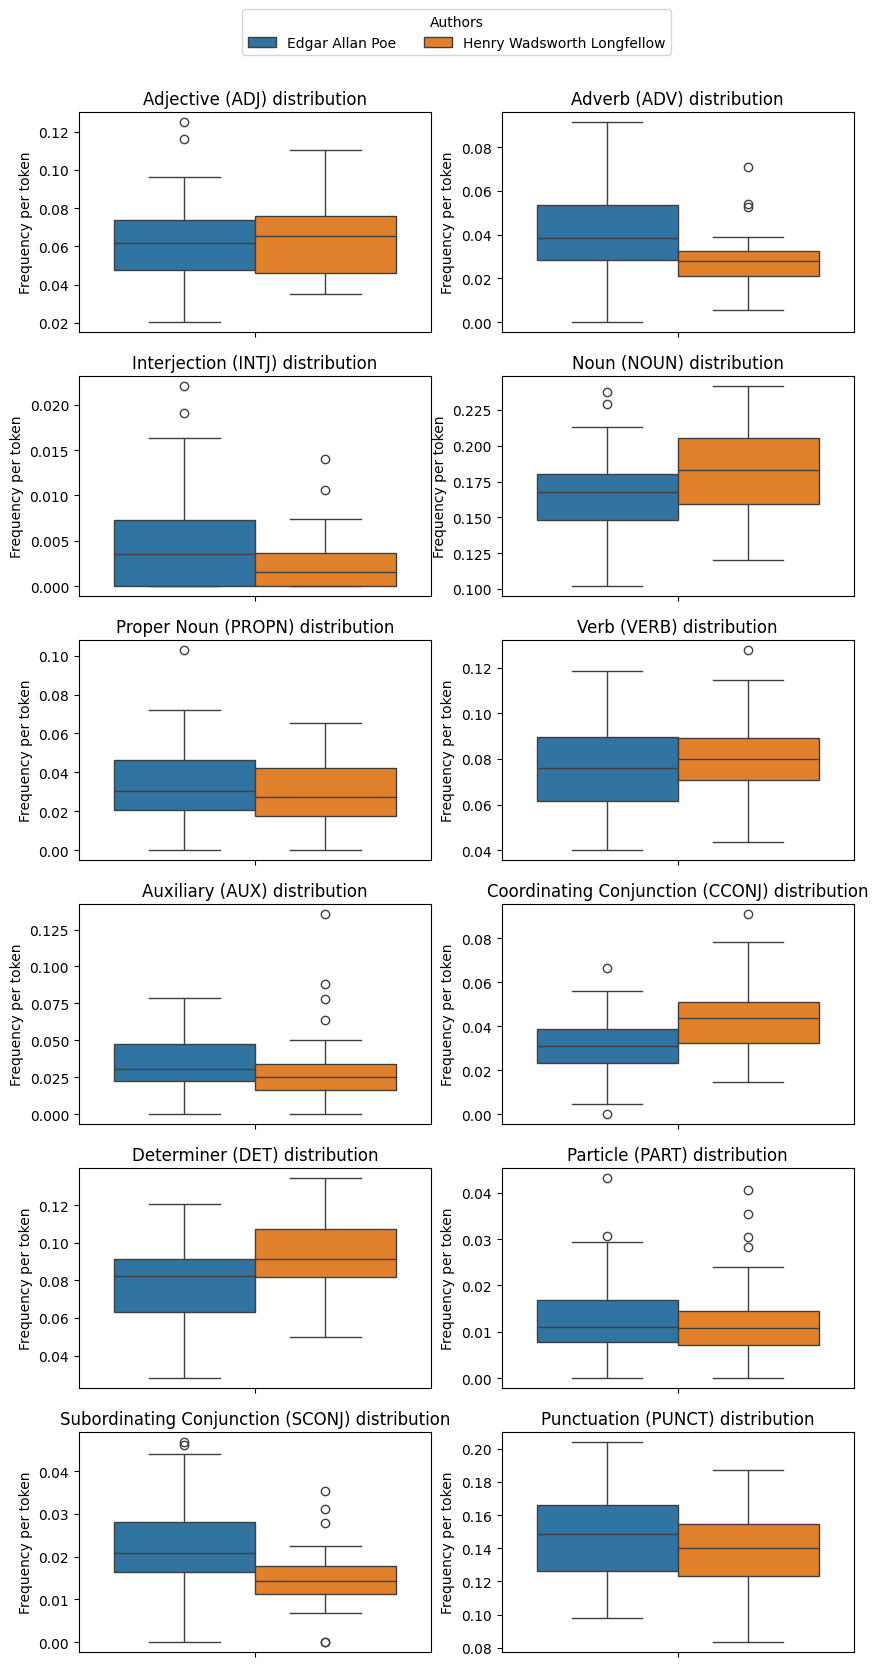

In [79]:
# make one figure in which we will place all the plots
_, axes = plt.subplots(6, 2, figsize=(10, 20))
ax = axes.flatten()

# add each plot to the figure, only use the legend of the first plot to avoid repeating the same legend for each plot
for num, pos_tag in enumerate(pos_tags):
    sns.boxplot(data=df, hue='author', y=pos_tag, legend=True if num == 0 else False, ax=ax[num])
    
    ax[num].set_title(f'{spacy.explain(pos_tag).title()} ({pos_tag}) distribution')
    ax[num].set_ylabel(f'Frequency per token')

    if num == 0:
        # place the legend centered at the top of the figure
        sns.move_legend(
                ax[num], 
                "upper right", 
                bbox_to_anchor=(1.7, 1.5), 
                ncol=len(df['author'].unique()), 
                title='Authors', 
                frameon=True
            )

# show the resulting plot
plt.show()